In [1]:
import torch
import matplotlib.pyplot as plt

import math
from torch.nn.functional import conv1d
from torch.nn.functional import pad

plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = 'serif'

In [2]:
# define signal and kernel
L = 100
x = torch.linspace(0, 2*torch.pi, L)
freq = 5
u = torch.sin(freq * x)

M = 30
x = torch.linspace(-2, 2, M) 
h = torch.exp(- x.pow(2))

# toeplitz utilities
def centered_toeplitz(h, L, M):
    T = torch.zeros(L - M + 1, L)

    T[0, :M] = h
    for i in range(1, L - M + 1): T[i] = torch.roll(T[i-1], 1)
    return T

def full_toeplitz(h, L, M):
    T = torch.zeros(L + M - 1, L)
    for i in range(M): T[i, :i+1] = h[-i-1:]
    for i in range(M, L): T[i] = torch.roll(T[i-1], 1)
    for i in range(L, L + M - 1):
        T[i, -M+i-L+1:] = h[:-i-1+L]
    return T

def circular_toeplitz(h, L, M):
    T = torch.zeros(L, L)
    T[0, :1] = h[0]
    T[0, -M+1:] = h[1:].flip(0)
    for i in range(1, L): T[i] = torch.roll(T[i-1], 1)
    return T

## Convolutions via DFT

In [3]:
def dft_matrix(L):
    kx = ky = torch.arange(0, L)
    kx = kx[:, None]
    ky = ky[None, :]
    W = torch.exp(-2j * torch.pi * kx * ky / L) / math.sqrt(L)
    return W

W = dft_matrix(L)

assert torch.allclose(W, W.T, atol=1e-4) # symmetric
assert torch.allclose((W @ W.conj()).real, torch.eye(L), atol=1e-4) # unitary

Text(0.5, 1.0, 'Imaginary part of the DFT matrix')

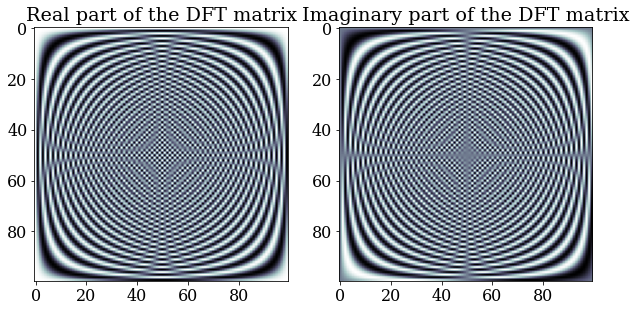

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(W.real, cmap='bone')
axs[0].set_title('Real part of the DFT matrix')

axs[1].imshow(W.imag, cmap='bone')
axs[1].set_title('Imaginary part of the DFT matrix')

In [5]:
matmul_dft = torch.matmul(W, u + 0j)
base_dft = torch.fft.fft(u, norm='ortho')

assert torch.allclose(matmul_dft, base_dft, atol=1e-4)

In [6]:
T = circular_toeplitz(h, L, M) + 0j

In [7]:
H = W @ T @ W.conj().T

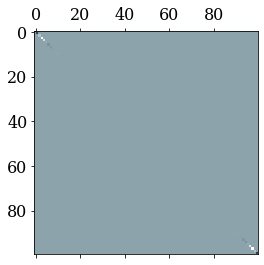

In [8]:
plt.matshow(H.real, cmap='bone_r')

assert torch.allclose(H.diag().abs().sum(), H.abs().sum(), rtol=1e-3)

What just happened? We diagonalized the circular Toeplitz matrix by $W T W^H$ where $W$ is the DFT matrix and $^H$ denotes the conjugate transpose. The Fourier convolution theorem in action!

One caveat: the Toeplitz matrix we just diagonalized does not correspond to neither of the two versions we have seen
in `basics.ipynb`. It is not a centered convolution, or a regular convolution. What is it then?

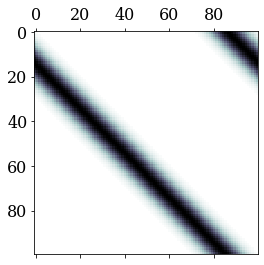

In [9]:
plt.matshow(T.real, cmap='bone_r')

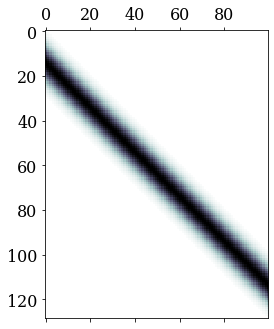

In [10]:
T_full = full_toeplitz(h, L, M) 

plt.matshow(T_full, cmap='bone_r')

The "circular" Toeplitz looks like the matrix above with a wrap-around... It is a circulant matrix!

In [11]:
T_circ = circular_toeplitz(h, L, M) 
T_cent = centered_toeplitz(h, L, M)
T_full = full_toeplitz(h, L, M)

Text(0.5, 1.0, 'Full convolution')

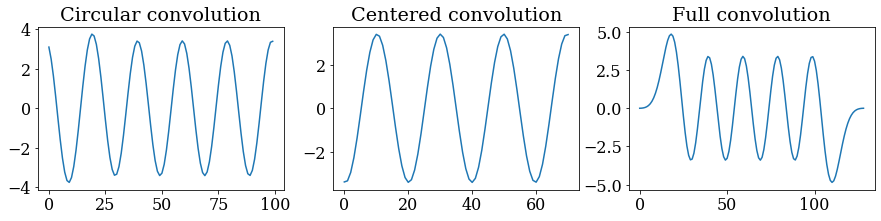

In [12]:
hu_circ = T.real @ u
hu_cent = T_cent @ u
hu_full = T_full @ u

fig, axs = plt.subplots(1, 3, figsize=(15, 3))

axs[0].plot(hu_circ)
axs[0].set_title('Circular convolution')

axs[1].plot(hu_cent)
axs[1].set_title('Centered convolution')

axs[2].plot(hu_full)
axs[2].set_title('Full convolution')


The circular convolution result does not look like those explored in the `basics`. However, the fact that that its corresponding matrix multiplication form is so easily diagonalizable makes it an important operation.

In practice, we often assume to be working with regular or centered convolutions. One easy way to perform a full convolution via a circular convolution is to once again pad the input:

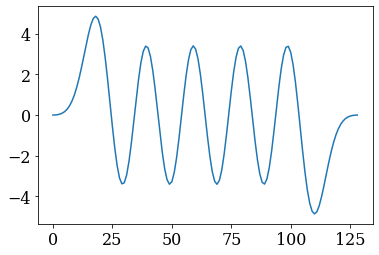

In [13]:
# recall that the support of a full convolution is of length L + M - 1

T = circular_toeplitz(h, L + M - 1, M)

u_pad = pad(u, (0, M - 1))

hu = T @ u_pad

plt.plot(hu)

Why does the above work? Think about the interaction of the wrap-around "terms" (top-right in the circulant matrix) and the padded values. 

We can 
leverage the diagonal form $W T W^H$ to compute $T u$ without the dense matrix multiply or the recurrent form, via a Fast Fourier Transform (which is an efficient way to compute $y = W u$ for
a given input $u$). Consider the change of coordinates:

$$
\begin{aligned}
\hat{u} &= W u \\
\hat{T} &= W T W^H \\
\hat{y} &= W y
\end{aligned}
$$

Then,

$$
\begin{aligned}
\hat{y} &= \hat{T}\hat{u} \\
\hat{y} &= \text{diag}(W T W^H) \circ W u
\end{aligned}
$$

With a final change of coordinates
$$
y = W^H \hat{y}.
$$


... and you can do this in PyTorch of course:

In [14]:
h_pad = pad(h, (0, L - 1)) 
# we pad the kernel with zeros to match the length of the signal for the element-wise multiplication
# the reason behind padding "first" is that the convolution implicitly flips the kernel. 
# In this example, this does not matter as the kernel is symmetric around its center point. 
U = torch.fft.fft(u_pad)
H = torch.fft.fft(h_pad, norm='ortho')
hu_base = torch.fft.ifft(U * H, norm='ortho')

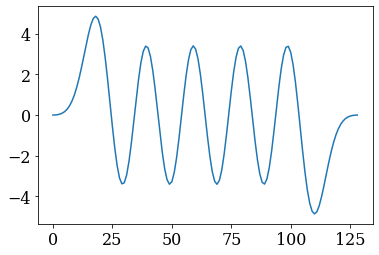

In [15]:
plt.plot(hu_base.real)

As a final note, $ \text{diag}(W T W^H) $ is usually computed as $W h$, since 

$$
\frac{1}{\sqrt{L}}\text{diag}(W T W^H) = W h
$$

Check! 

Going forward, we always consider normalized (unitary) DFT matrices.

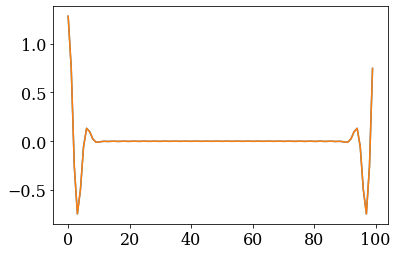

In [16]:
T = circular_toeplitz(h, L, M) + 0 * 1j

h_pad = pad(h, (0, L - M))
plt.plot((W @ (h_pad + 0*1j)).real)
plt.plot((W @ T @ W.T.conj()).diag().real / math.sqrt(L))
